# Fitting the Calibration Model on the Baseline Data. 

In [1]:
import pandas as pd
from os.path import join
import numpy as np
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
sns.set_theme()

import sys
sys.path.append('/home/monte.flora/python_packages/ml_workflow')

from ml_workflow import DateBasedCV
from ml_workflow.ml_methods import norm_aupdc, norm_csi
from sklearn.metrics import roc_auc_score

In [2]:
def scorer(model, X, y, **kwargs ):
    known_skew = kwargs.get('known_skew', np.mean(y))
    predictions = model.predict(X)
    return norm_aupdc(y, predictions, known_skew=known_skew)
    #return roc_auc_score(y, predictions)
    
def cv_scorer(X, y, dates):
    known_skew = np.mean(y)
    
    cv = DateBasedCV(n_splits=30, dates=dates, y=y, valid_size=0.2)
    cv_scores = []
    for train_inds, test_inds in cv.split(X):
        clf = IsotonicRegression(out_of_bounds='clip', y_min=0, y_max=1)
        clf.fit(X[train_inds], y[train_inds])
        cv_scores.append(scorer(clf, X[test_inds], y[test_inds], known_skew=known_skew))
    
    return cv_scores

In [3]:
from mlxtend.evaluate import permutation_test
def stat_testing(new_score, baseline_score):
    """
    Compute a p-value between two sets using permutation testing 
    to determined statistical significance. In this case,
    assess whether the ML performance is greater than the baseline.
    """
    p_value = permutation_test(new_score,
                              baseline_score,
                             'x_mean != y_mean',
                              method='approximate',
                               num_rounds=1000,
                               seed=0)
    return p_value

In [4]:
lead_time = 'first_hour'
target = 'tornado'
old_target = 'tornado'

base_path = '/work/mflora/ML_DATA/DATA'
fname = join(base_path, f'{lead_time}_whole_dataset.pkl')
old_train_df = pd.read_pickle(fname)
old_dates = old_train_df['Run Date'].apply(str)

In [5]:
base_path = '/work/mflora/ML_DATA/DATA'
#train_df = pd.read_feather(join(base_path, f'wofs_ml_severe__{time}__train_baseline_data.feather'))
train_df = pd.read_feather(join(base_path, f'wofs_ml_severe__{lead_time}__baseline_data.feather'))
print(len(train_df))

1013381


In [6]:
dates = train_df['Run Date'].apply(str)
train_df = train_df[dates.isin(np.unique(old_train_df['Run Date']))]
dates = train_df['Run Date'].apply(str)
train_df = train_df[pd.to_datetime(dates).dt.strftime('%Y').isin(['2017', '2018', '2019'])]
train_df.reset_index(inplace=True, drop=True)
dates = train_df['Run Date'].apply(str)

In [7]:
old_mapper = {'tornado' : 'uh_probs', 
          'severe_wind' : 'wnd_probs',
          'severe_hail' : 'hail_probs',
         }

var_set = [c for c in old_train_df.columns if old_mapper[old_target] in c ]
old_rng = [float(v.split('_')[2].replace('>','')) for v in var_set]

old_y = old_train_df[f'matched_to_{old_target}_0km'].values.astype(float) 
org_scores = [ cv_scorer(old_train_df[v].values, old_y, old_dates) for v in var_set]

In [8]:
colors = sns.color_palette()
old_scores = org_scores[2]

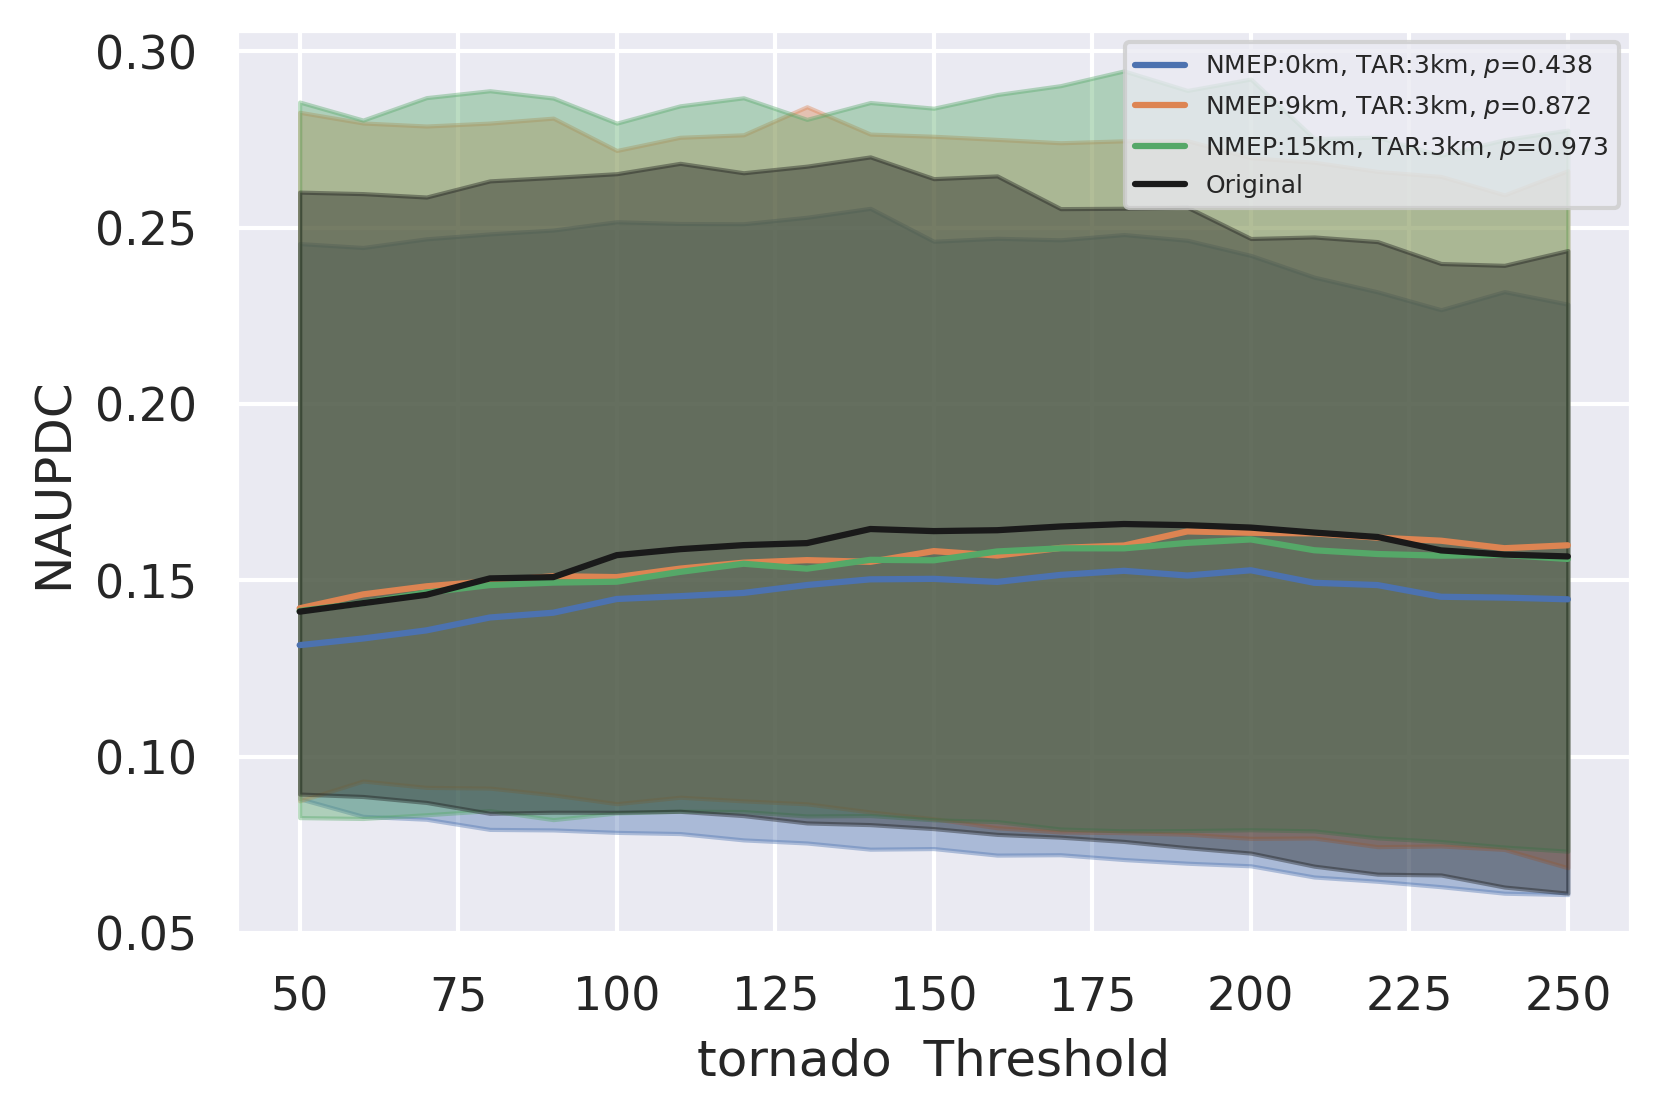

In [9]:
mapper = {'tornado' : 'uh_nmep', 
          'wind' : 'wind_nmep',
          'hail' : 'hail_nmep',
         }

nmep_nghbrds = ['0km', '9km', '15km',]# '27km'] 
target_nghbrds = ['3km']# '9km', '15km',]# '30km'] 

f, ax = plt.subplots(dpi=300)

for i, (n, k) in enumerate(itertools.product(nmep_nghbrds, target_nghbrds)): 
    var_set = [c for c in train_df.columns if mapper[target] in c ]
    var_set_subset = [v for v in var_set if n in v]
    rng = [float(v.split('_')[2].replace('>','')) for v in var_set_subset]
    
    y = train_df[f'{target}_severe_{k}'].values
    scores = [ cv_scorer(train_df[v].values ,y, dates) for v in var_set_subset]
    
    new_scores = scores[2]
    
    p_val = stat_testing(new_scores, old_scores)
    
    ymean = np.mean(scores, axis=-1)
    lower_bound, upper_bound = np.percentile(scores, [2.5, 97.5], axis=-1)
    yerr = np.array([ymean-lower_bound, upper_bound-ymean])
    ax.plot(rng, ymean, label = fr'NMEP:{n}, TAR:{k}, $p$={p_val:.3f}', color=colors[i])
    ax.fill_between(rng, lower_bound, upper_bound, color=colors[i], alpha=0.4)
    
ymean = np.mean(org_scores, axis=-1)
lower_bound, upper_bound = np.percentile(org_scores, [2.5, 97.5], axis=-1)
yerr = np.array([ymean-lower_bound, upper_bound-ymean])
ax.plot(old_rng, ymean, label='Original', color='k')
ax.fill_between(old_rng, lower_bound, upper_bound, color='k', alpha=0.4)

ax.set_xlabel(f'{target}  Threshold')
ax.set_ylabel('NAUPDC')   
ax.legend(fontsize=6)